# Trivial Endpoints

A "trivial" endpoint is a fixed point or a global optimum that consists of a singleton theory (e.g. $T=\lbrace s_{1}\rbrace$) and a singleton commitment (e.g. $C = \lbrace s_{1}\rbrace$). 

Such outcomes are not bad per se, but they may be indicative of the model exploiting shortcomings in the underlying measures. In particular, "trivial" endpoints may be a consequence of the original model's shortcoming concerning the measure of systematicity, which and does not discriminate between singleton theories on the basis of the scope of theories. Note that the same shortcoming also applies to the model variants explored in this report.

In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [4]:
coolwarm = ['#6788ee', '#9abbff', '#e26952', '#f7a889']

### Utility

In [6]:
# working on strings directly in order to avoid having to literal_eval millions of strings

def get_length(pos):
    return len(pos.split(","))

def get_lengths(x, pos_type):
    
    # split the list of endpoint tuples 
    l = x.split('), (')

    # split each endpoint tuple into a theory and a commitment position (set representation with {})
    l = [s.split('}, {') for s in l]
    
    if not pos_type in ["theory", "commitments"]:
        raise ValueError("pos_type must be 'theory' or 'commitments'")
    
    idx = 0 if pos_type == "theory" else 1
     
    # length of the first (theory) or second (commitments) element  after 
    # the comma-separated sentences have been split
    return [len(s[idx].split(',')) for s in l]

## Loading Data

In [7]:
# relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha'
data_file_name = f'{data_set_name}.csv' #.tar.gz'

In [8]:
# output directory
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [38]:
re_data = load_re_data(data_dir, 
                                data_file_name,
                                usecols = ["model_name",
                                           'n_sentence_pool',
                                           "ds",
                                           "init_coms",
                                           'weight_account', 
                                           'weight_systematicity',
                                           "n_fixed_points",
                                           "n_global_optima",
                                           'error_code',
                                           'fixed_points',
                                           'global_optima',
                                           'fixed_point_coms',
                                           'fixed_point_theory',
                                           ],
                               evalcols = ['x'], # dummy column to circumvent literal evaluation
                      filter_erroneous_runs = True)

In [39]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 4136547
   Number of dialectical structures: 200
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [40]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'fixed_point_coms',
       'fixed_point_theory', 'error_code', 'fixed_points', 'n_fixed_points',
       'global_optima', 'n_global_optima', 'model_short_name'],
      dtype='object')

## Dataframe setup

In [72]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point, 
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setups
"""

# Currently, no information concerning account/faithfulness values is stored in branches.
analyse_branches = True

"""Whether bootstrapping is applied to estimate mean and standard deviation"""
bootstrap = True
n_resamples = 400


grouping = ["model_name"]

# Whether resulting tables and figures are exported to the corresponing output directory"""
export_results = True

In [73]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity', 
                         'init_coms'
                        ])

In [74]:
# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "n_sentence_pool",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity",
                                 "global_optima",
                                ]]

In [75]:
# add lengths of global optima theories and commitments

go_data["go_theory_len"] = go_data["global_optima"].apply(get_lengths, pos_type="theory")
go_data["go_coms_len"] = go_data["global_optima"].apply(get_lengths, pos_type="commitments")

In [76]:
# remove global_optima column
go_data = go_data[["model_name",
            "ds",
            "n_sentence_pool",
            "init_coms",
            "weight_account", 
            "weight_systematicity",
            #"global_optima",
            "go_theory_len",
            "go_coms_len"
            ]]

In [77]:
# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_full_re_state`)
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "n_sentence_pool",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity",
                                     ]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(2845799, 8)

In [78]:
re_data_unique_setups.groupby("model_name")["ds"].size().reset_index().sort_values("ds", ascending=False)

,model_name,ds
0,LinearGlobalRE,143973
2,QuadraticGlobalRE,143964
3,QuadraticLocalRE,143079
1,LinearLocalRE,142219


In [79]:
# two models variants for global optima graphics in order to avoid (almost) redundant results
# criterion:  fewest erroneous runs
go_models = ["LinearGlobalRE", "QuadraticGlobalRE"]

In [80]:
if analyse_branches:
    
    #raise ValueError("`analyse_branches` cannot be set to `true`")
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       'n_sentence_pool',
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       'fixed_point_theory',
                       'fixed_point_coms']]
    
    # rename fixed point columns 
    # note: df is already exploded
    exploded_fp_data = fp_data #.rename(columns={'fixed_point': "fixed_points",})
    
    # add lengths of fixed points theories and commitments
    exploded_fp_data["fp_theory_len"] =  exploded_fp_data['fixed_point_theory'].apply(get_length)
    exploded_fp_data["fp_coms_len"] =  exploded_fp_data['fixed_point_coms'].apply(get_length)
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "n_sentence_pool",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity",
                                     "fixed_points",
                                    ]]
    
    # add lengths of fixed points theories and commitments
    fp_data["fp_theory_len"] = fp_data["fixed_points"].apply(get_lengths, pos_type="theory")
    fp_data["fp_coms_len"] = fp_data["fixed_points"].apply(get_lengths, pos_type="commitments")
    
    # remove fixed_points column
    fp_data = fp_data[["model_name",
                       "ds",
                       "n_sentence_pool",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity",
                       'fp_theory_len',
                       "fp_coms_len"
                                    ]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `fp_full_re_state`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "n_sentence_pool",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(4136547, 10)

In [81]:
# trivial endpoints consist of a singletion theory and a single commitment
exploded_go_data["go_trivial"] = (exploded_go_data["go_theory_len"]==1) & (exploded_go_data["go_coms_len"]==1)
exploded_fp_data["fp_trivial"] = (exploded_fp_data["fp_theory_len"]==1) & (exploded_fp_data["fp_coms_len"]==1)

### Tables

In [68]:
# separate tables for go and fp

for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = None
    


    result_df = rel_share_of_property(df, 
                           "{}_trivial".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols=['model_name'],
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    result_df.reset_index(inplace=True)
    

            
    # for later use
    if endpoint_type == "go":
        go_result_df = result_df
    else:
        fp_result_df = result_df
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                       'sum_fp_trivial': 'Number of trivial fixed points',
                       'size_fp_trivial': 'Number of fixed points',
                       'rel_fp_trivial': 'Relative share of trivial fixed points',
                       'sum_go_trivial': 'Number of trivial global optima',
                       'size_go_trivial': 'Number of global optima',
                       'rel_go_trivial': 'Relative share of trivial global optima',
                       'std_go_trivial': 'Standard deviation GO',
                       'std_fp_trivial': 'Standard deviation FP',
                  }
    renamed_result_df = result_df.rename(columns=cols_for_tables)
    
    # restrict to most relevant columns
    retain_columns = [col for col in renamed_result_df.columns if (("size" not in col) and ("sum" not in col))]
    
    renamed_result_df = renamed_result_df[retain_columns]

    display(renamed_result_df)
    
    # Exporting relevant cols
    if export_results:
        file_name = 'table_trivial_{}_{}.csv'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        renamed_result_df.to_csv(path.join(tables_output_dir, file_name), index=False)

,Model,Relative share of trivial global optima,Standard deviation GO,Number of trivial global optima,Number of global optima
2,QuadraticGlobalRE,0.009267,0.000117,6625,714584
0,LinearGlobalRE,0.080806,0.000342,56635,700830
3,QuadraticLocalRE,0.009344,0.000109,6625,709289
1,LinearLocalRE,0.069683,0.000307,50256,721096


,Model,Relative share of trivial fixed points,Standard deviation FP,Number of trivial fixed points,Number of fixed points
2,QuadraticGlobalRE,0.008071,0.000129,3698,458147
0,LinearGlobalRE,0.080264,0.000499,25111,312783
3,QuadraticLocalRE,0.008833,0.000120,5189,588236
1,LinearLocalRE,0.063349,0.000487,14443,228122


### Resiults Grouped by Sentence Pool Size

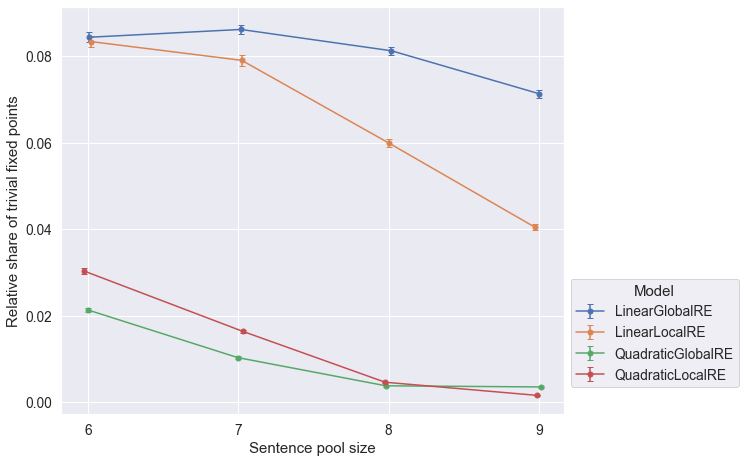

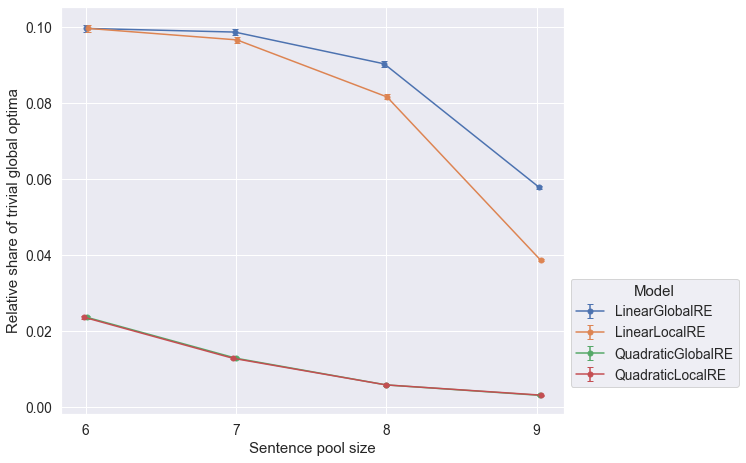

In [69]:
grouping = ['model_name',
            'n_sentence_pool',]

for df, endpoint_type in zip([exploded_fp_data, exploded_go_data], ["fp", "go"]):
  
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
    
    result_df = rel_share_of_property(df, 
                           "{}_trivial".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols= grouping,
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    
    perspective = "pp" if analyse_branches else "rp"
    
    file_name = None
    if export_results:
        file_name = f"rel_{endpoint_type}_trivial_by_sp_{perspective}"
    
    
    
    plot_multiple_error_bars(result_df.reset_index(), 
                             var_y = f"rel_{endpoint_type}_trivial", 
                             ylabel = f"Relative share of trivial {endpoint}",
                             xlabel = "Sentence pool size",
                             var_std=f"std_{endpoint_type}_trivial",
                             file_name=file_name,
                             output_dir = figures_output_dir)
    
    plt.show()

### Heatmaps

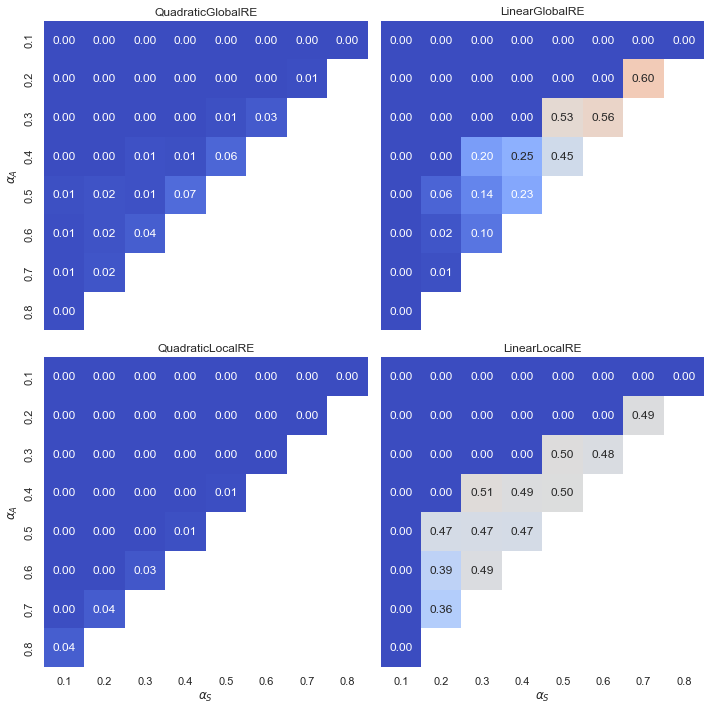

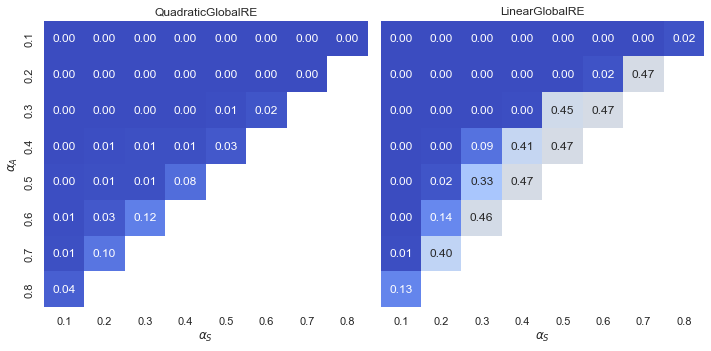

In [82]:
for df, endpoint_type in zip([exploded_fp_data, exploded_go_data], ["fp", "go"]):
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        df = df[df["model_name"].isin(go_models)]
    
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"

    heat_maps_by_weights(re_data = df, 
                     values = "{}_trivial".format(endpoint_type), 
                     #title = "Relative share of trivial {}".format(endpoint),
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.3f}',
                     vmin=0,
                     vmax=1,
                     bootstrap=bootstrap,
                     n_resamples=n_resamples)
    
    

    branches = "pp" if analyse_branches else "rp"

    if export_results:
        plt.savefig(path.join(figures_output_dir, 'rel_trivial_{}_{}.png'.format(endpoint_type, branches)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'rel_trivial_{}_{}.pdf'.format(endpoint_type, branches)), bbox_inches='tight')
        
    plt.show()